In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import mplhep as hep 
import uproot
from scipy.stats import bootstrap
from scipy.special import factorial
from scipy.optimize import curve_fit
plt.style.use(hep.style.CMS)

In [3]:
#file_names=['./NoNoise/2channel/Na22_nearest.root','./NoNoise/2channel/Na22_Nearest2.root','./NoNoise/2channel/Na22_Nearest3.root','./WithNoise/2channel/Na22_nearest.root','./WithNoise/2channel/Na22_Nearest2.root','./WithNoise/2channel/Na22_Nearest3.root']#,'./WithNoise/2channel/Na22_nearest.root']
file_names=['NoNoise/1channel/Co60_Nearest.root','NoNoise/1channel/Na22_nearestWN.root','NoNoise/1channel/Cs137_Nearest.root']
uproot.open(file_names[0])['SiPM'].keys()

['EventID', 'Area', '#RealPhoton', '#PE', '#NoisePE', 'Time_Of_Triggering_ns']

Locator attempting to generate 1959 ticks ([-18.400000000000002, ..., 373.20000000000005]), which exceeds Locator.MAXTICKS (1000).


Co60 Probability=0.0001
[40, 43, 44, 45, 46, 47, 48, 50, ..., 348, 349, 350, 351, 352, 353, 354, 355]
Na22 Probability=0.0001
[36, 37, 38, 39, 40, 41, 42, 44, ..., 262, 263, 264, 265, 266, 267, 268, 269]
Cs137 Probability=0.0001
[24, 25, 27, 28, 29, 30, 31, 32, ..., 335, 336, 337, 338, 339, 340, 341, 342]


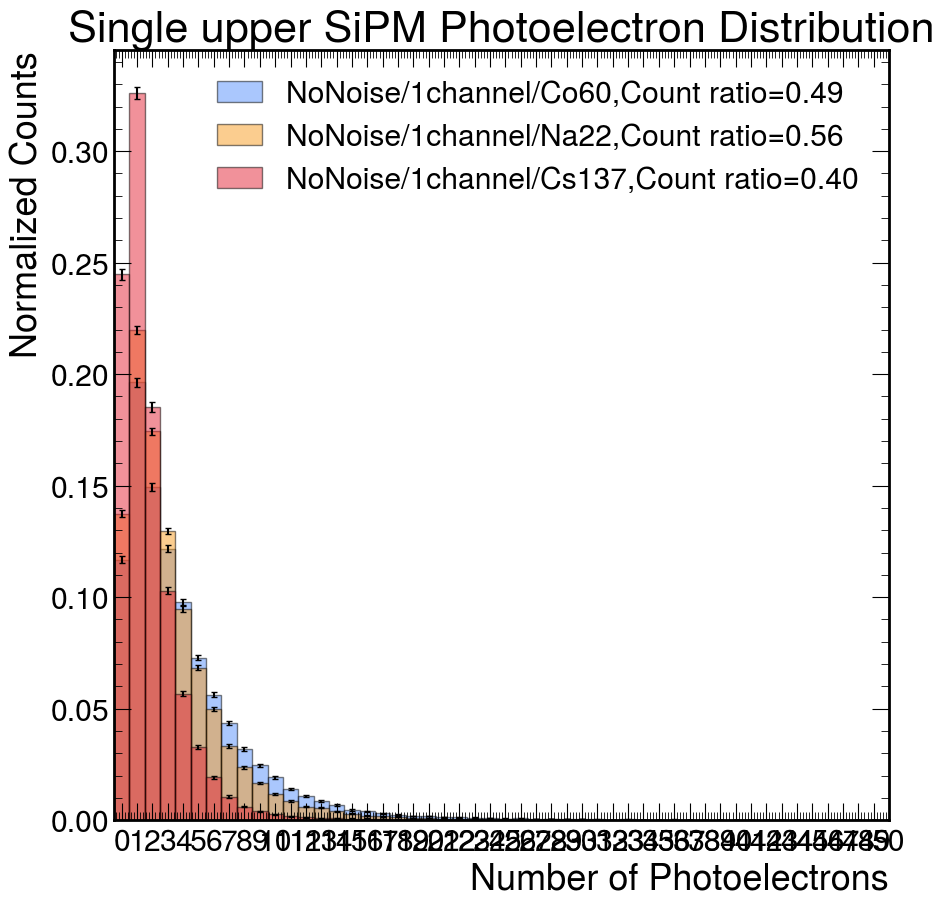

In [19]:
for i in range(len(file_names)):
    data=uproot.open(file_names[i])['SiPM']['#PE'].array()-uproot.open(file_names[i])['SiPM']['#NoisePE'].array()
    n=np.max(data)
    bins = np.arange(start=-0.5, stop=(n+1), step=1)
    # Plot the histogram
    plt.hist(data, bins=bins, density=True,edgecolor='k', alpha=0.5,label=file_names[i].split('_')[0]+",Count ratio=%.2f"%(len(data)/100000))
    # error bars
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    p=1/10000
    print(file_names[i].split('/')[2].split('_')[0]+" Probability=%s"%(p))
    print(bin_centers[counts/np.sum(counts)<=p])
    # Poisson errors
    errors = np.sqrt(counts) / np.sum(counts)
    plt.errorbar(bin_centers, counts/np.sum(counts), yerr=errors, fmt='none', ecolor='k', capsize=2)

    
plt.xticks(np.arange(50+1))
plt.xlabel('Number of Photoelectrons')
plt.ylabel('Normalized Counts')
plt.title('Single upper SiPM Photoelectron Distribution')
plt.xlim(-0.5,50)
plt.legend()

Locator attempting to generate 1959 ticks ([-18.400000000000002, ..., 373.20000000000005]), which exceeds Locator.MAXTICKS (1000).


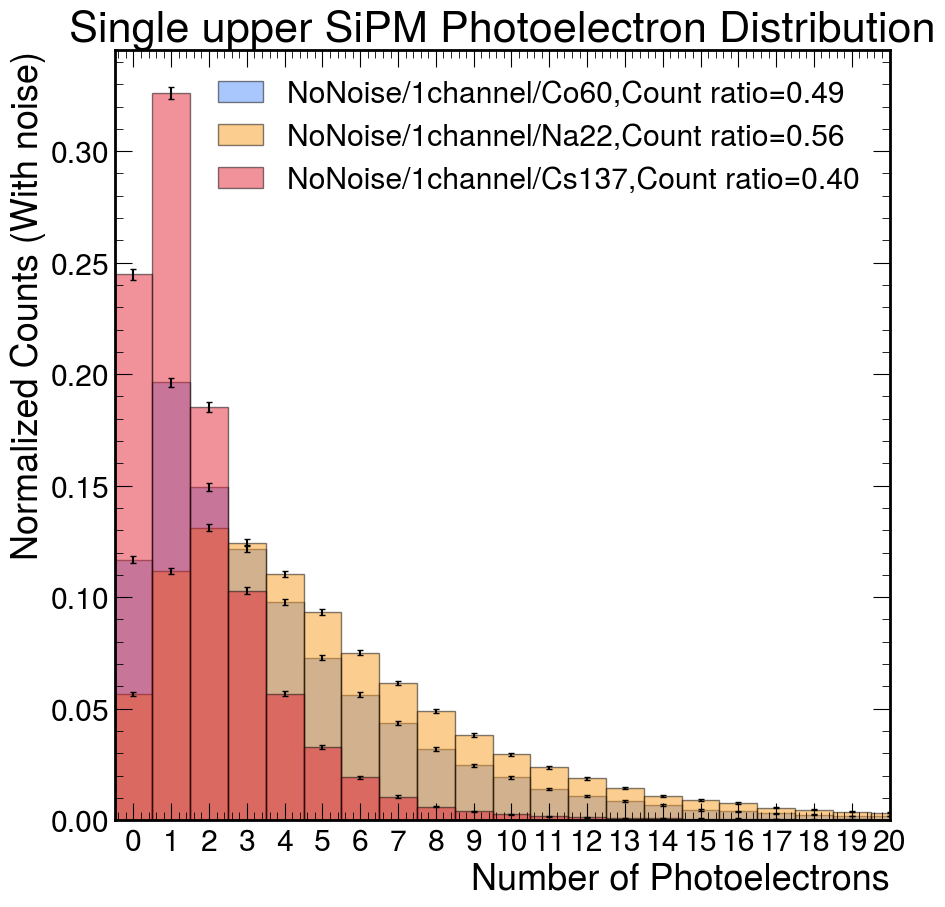

In [31]:
for i in range(len(file_names)):
    data=uproot.open(file_names[i])['SiPM']['#PE'].array()
    n=np.max(data)
    bins = np.arange(start=-0.5, stop=(n+1), step=1)
    # Plot the histogram
    plt.hist(data, bins=bins, density=True,edgecolor='k', alpha=0.5,label=file_names[i].split('_')[0]+",Count ratio=%.2f"%(len(data)/100000))
    # error bars
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Poisson errors
    errors = np.sqrt(counts) / np.sum(counts)
    plt.errorbar(bin_centers, counts/np.sum(counts), yerr=errors, fmt='none', ecolor='k', capsize=2)
    # Fit Gaussian to the first peak
    
    
    

    
plt.xticks(np.arange(20+1))
plt.xlabel('Number of Photoelectrons')
plt.ylabel('Normalized Counts (With noise)')
plt.title('Single upper SiPM Photoelectron Distribution')
plt.xlim(-0.5,20)
plt.legend()

# Resolutions

In [5]:
file_names=[]
E_list=[]
for i in np.arange(100,1300,100):
    file_names.append("WithNoise/1channel/Calibration/Energy_%s.root"%(i))
    E_list.append(int(i))
uproot.open(file_names[0])['SiPM'].keys()

['EventID', 'Area', '#RealPhoton', '#PE', '#NoisePE', 'Time_Of_Triggering_ns']

In [6]:
# Energy resolution
# Real photon vs PE
RPC=[]
PEC=[]
AreaC=[]
for i in range(len(file_names)):
    Energy_label=E_list[i]
    data=uproot.open(file_names[i])['SiPM']
    RealPhotonCount=data["#RealPhoton"].array().to_numpy()
    PhotoelectricCount=data["#PE"].array().to_numpy()
    AreaCount=data["Area"].array().to_numpy()
    RPC.append([Energy_label,RealPhotonCount.mean(), RealPhotonCount.std()])
    PEC.append([Energy_label,PhotoelectricCount.mean(), PhotoelectricCount.std()])
    AreaC.append([Energy_label,AreaCount.mean(), AreaCount.std()])
RPC=np.array(RPC)
PEC=np.array(PEC)
AreaC=np.array(AreaC)

In [7]:
mydat=[]
rngs = np.random.default_rng(234893458942534)
Re = lambda x, axis: np.std(x, axis=axis, ddof=1) / np.mean(x, axis=axis)
for i in range(len(file_names)):
    Energy_label=E_list[i]
    data=uproot.open(file_names[i])['SiPM']
    RealPhotonCount=data["#RealPhoton"].array().to_numpy()
    bootstrap_ci = bootstrap((RealPhotonCount,), Re, confidence_level=0.95,n_resamples=10000,batch=None,method='basic', random_state=rngs,vectorized=True)
    ci_low, ci_high = bootstrap_ci.confidence_interval
    mean_value = bootstrap_ci.bootstrap_distribution.mean()
    mydat.append([Energy_label,mean_value,np.abs(mean_value-ci_low),np.abs(mean_value-ci_high)])
mydat.sort(key=lambda x: x[0])
mydat=np.array(mydat)
X_label_Photon=mydat[:,0]
Y_label_Photon=mydat[:,1]
Y_err_Photon=[mydat[:,2],mydat[:,3]]
mydat=[]
rngs = np.random.default_rng(234893458942534)
Re = lambda x, axis: np.std(x, axis=axis, ddof=1) / np.mean(x, axis=axis)
for i in range(len(file_names)):
    Energy_label=E_list[i]
    data=uproot.open(file_names[i])['SiPM']
    PhotoelectricCount=data["#PE"].array().to_numpy()
    bootstrap_ci = bootstrap((PhotoelectricCount,), Re, confidence_level=0.95,n_resamples=10000,batch=None,method='basic', random_state=rngs,vectorized=True)
    ci_low, ci_high = bootstrap_ci.confidence_interval
    mean_value = bootstrap_ci.bootstrap_distribution.mean()
    mydat.append([Energy_label,mean_value,np.abs(mean_value-ci_low),np.abs(mean_value-ci_high)])
mydat.sort(key=lambda x: x[0])
mydat=np.array(mydat)
X_label_PE=mydat[:,0]
Y_label_PE=mydat[:,1]
Y_err_PE=[mydat[:,2],mydat[:,3]]
mydat=[]
rngs = np.random.default_rng(234893458942534)
Re = lambda x, axis: np.std(x, axis=axis, ddof=1) / np.mean(x, axis=axis)
for i in range(len(file_names)):
    Energy_label=E_list[i]
    data=uproot.open(file_names[i])['SiPM']
    AreaCount=data["Area"].array().to_numpy()
    bootstrap_ci = bootstrap((AreaCount,), Re, confidence_level=0.95,n_resamples=10000,batch=None,method='basic', random_state=rngs,vectorized=True)
    ci_low, ci_high = bootstrap_ci.confidence_interval
    mean_value = bootstrap_ci.bootstrap_distribution.mean()
    mydat.append([Energy_label,mean_value,np.abs(mean_value-ci_low),np.abs(mean_value-ci_high)])
mydat.sort(key=lambda x: x[0])
mydat=np.array(mydat)
X_label_Area=mydat[:,0]
Y_label_Area=mydat[:,1]
Y_err_Area=[mydat[:,2],mydat[:,3]]

/tmp/ipykernel_583495/2726055573.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(X_label_PE, Y_label_PE, yerr=Y_err_PE, label='Photoelectric Count', marker='o',fmt='o', capsize=3)


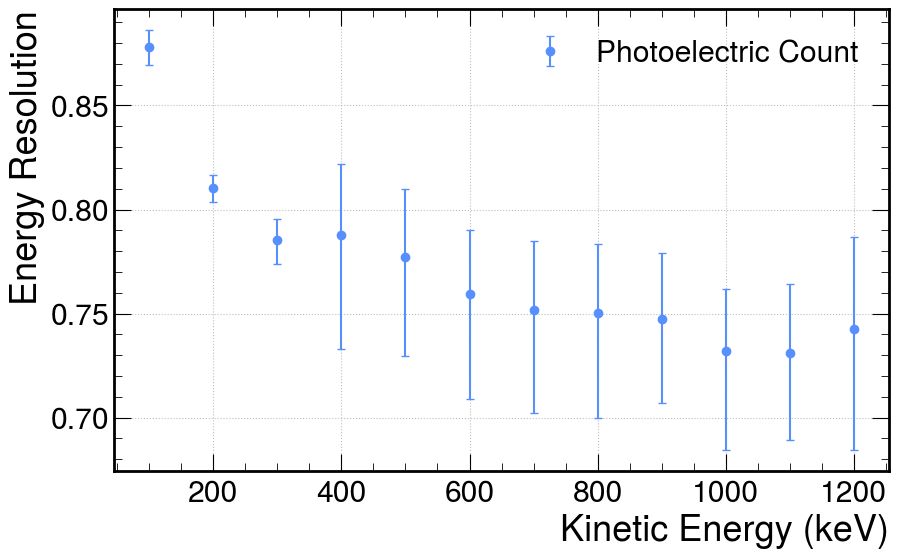

In [8]:
plt.figure(figsize=(10, 6))
#plt.errorbar(X_label_Photon, Y_label_Photon, yerr=Y_err_Photon, label='Real Photon Count', marker='o',fmt='o', capsize=3)
plt.errorbar(X_label_PE, Y_label_PE, yerr=Y_err_PE, label='Photoelectric Count', marker='o',fmt='o', capsize=3)
#plt.errorbar(X_label_Area, Y_label_Area, yerr=Y_err_Area, label='Area Count', marker='o',fmt='o', capsize=3)
plt.xlabel('Kinetic Energy (keV)')
plt.ylabel('Energy Resolution')
plt.legend()
plt.grid()
plt.show()

# Some Linearity

In [9]:
# Energy resolution
# Real photon vs PE
RPC=[]
PEC=[]
REALPEC=[]
AreaC=[]
for i in range(len(file_names)):
    Energy_label=E_list[i]
    data=uproot.open(file_names[i])['SiPM']
    RealPhotonCount=data["#RealPhoton"].array().to_numpy()
    PhotoelectricCount=data["#PE"].array().to_numpy()
    AreaCount=data["Area"].array().to_numpy()
    RealPE_Count=PhotoelectricCount-data["#NoisePE"].array().to_numpy()
    RPC.append([Energy_label,RealPhotonCount.mean(), RealPhotonCount.std()])
    PEC.append([Energy_label,PhotoelectricCount.mean(), PhotoelectricCount.std()])
    AreaC.append([Energy_label,AreaCount.mean(), AreaCount.std()])
    REALPEC.append([Energy_label,RealPE_Count.mean(), RealPE_Count.std()])
RPC=np.array(RPC)
PEC=np.array(PEC)
AreaC=np.array(AreaC)
REALPEC=np.array(REALPEC)

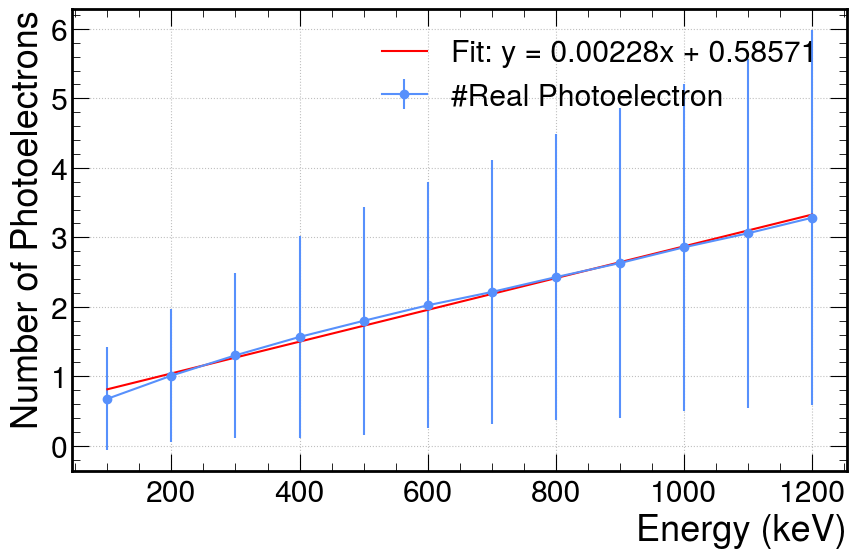

In [15]:
# Real photon vs PE
EnergyResolutionRPC = RPC[:, 1]
EnergyResolutionRPC_err = RPC[:, 2]
EnergyResolutionPEC = PEC[:, 1]
EnergyResolutionPEC_err = PEC[:, 2]
EnergyResolutionAreaC = AreaC[:, 1]
EnergyResolutionAreaC_err = AreaC[:, 2]
EnergyResolutionRealPEC=REALPEC[:,1]
EnergyResolutionRealPEC_err=REALPEC[:,2]
# Plotting the energy resolutions
plt.figure(figsize=(10, 6))
plt.errorbar(RPC[:, 0], EnergyResolutionRealPEC,yerr=EnergyResolutionRealPEC_err, label='#Real Photoelectron', marker='o')
#fit straight line
coefficients = np.polyfit(RPC[:, 0], EnergyResolutionRealPEC, 1)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(RPC[:, 0]), max(RPC[:, 0]), 100)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, label='Fit: y = %.5fx + %.5f' % (coefficients[0], coefficients[1]), color='red')

#plt.errorbar(EnergyResolutionRPC, EnergyResolutionAreaC, xerr=EnergyResolutionRPC_err, yerr=EnergyResolutionAreaC_err,label='#Photon vs #Area', marker='o')
plt.xlabel("Energy (keV)")
plt.ylabel("Number of Photoelectrons")
plt.legend()
plt.grid()

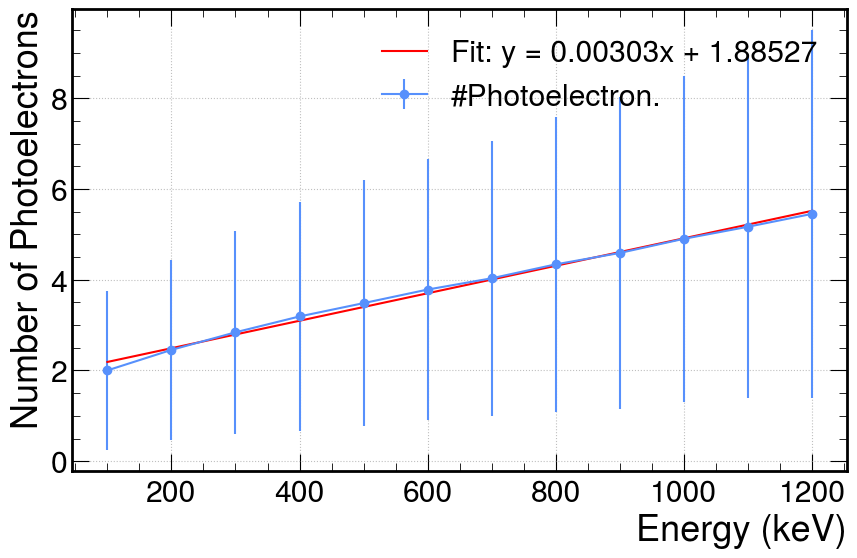

In [17]:
# Real photon vs PE
EnergyResolutionRPC = RPC[:, 1]
EnergyResolutionRPC_err = RPC[:, 2]
EnergyResolutionPEC = PEC[:, 1]
EnergyResolutionPEC_err = PEC[:, 2]
EnergyResolutionAreaC = AreaC[:, 1]
EnergyResolutionAreaC_err = AreaC[:, 2]
# Plotting the energy resolutions
plt.figure(figsize=(10, 6))
plt.errorbar(RPC[:, 0], EnergyResolutionPEC,yerr=EnergyResolutionPEC_err, label='#Photoelectron.', marker='o')
#fit straight line
coefficients = np.polyfit(RPC[:, 0], EnergyResolutionPEC, 1)
polynomial = np.poly1d(coefficients)
x_fit = np.linspace(min(RPC[:, 0]), max(RPC[:, 0]), 100)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, label='Fit: y = %.5fx + %.5f' % (coefficients[0], coefficients[1]), color='red')

#plt.errorbar(EnergyResolutionRPC, EnergyResolutionAreaC, xerr=EnergyResolutionRPC_err, yerr=EnergyResolutionAreaC_err,label='#Photon vs #Area', marker='o')
plt.xlabel("Energy (keV)")
plt.ylabel("Number of Photoelectrons")
plt.legend()
plt.grid()